In [46]:
#purpose: evaluate the performance of binary classification techniques (closest average, LDA, QDA) for classifying
# cat vs. dog images across various dimensions

In [1]:
# Import Necessary Modules
import glob
import matplotlib.pyplot as plt
import math
from skimage import io
import numpy as np
import pandas as pd


In [2]:
#This function reads in all images in catsfolder/ and dogsfolder/. 
#Each 64 x 64 image is reshaped into a length-4096 row vector. 
#These row vectors are stacked on top of one another to get two data
#matrices, each with 4096 columns. The first matrix cats consists of all
#the cat images as row vectors and the second matrix dogs consists of all
#the dog images as row vectors.

def read_cats_dogs():
    
    # get image filenames
    cat_locs = glob.glob('catsfolder/*.jpg')
    dog_locs = glob.glob('dogsfolder/*.jpg')

    num_cats = len(cat_locs)
    num_dogs = len(dog_locs)
    
    # initialize empty arrays
    cats = np.zeros((num_cats,64*64))
    dogs = np.zeros((num_dogs,64*64))
              
    #reshape images into row vectors and stack into a matrix 
    for i in range(num_cats):
        img = cat_locs[i]
        im = io.imread(img)
        im = im.reshape(64*64)
        cats[i,:] = im

    for i in range(num_dogs):
        img = dog_locs[i]
        im = io.imread(img)
        im = im.reshape(64*64)
        dogs[i,:] = im

    return cats, dogs

In [3]:
#This function takes in an n x 4096 data matrix X and an index i. It extracts
#the ith row of X and displays it as a grayscale 64 x 64 image.

def show_image(X, i):
    #select image
    image = X[i,:]
    #reshape make into a square
    image = image.reshape((64,64))
    #display the image
    plt.imshow(image,'gray')

In [4]:
#Split the data into numfolds equal-sized segments
numfolds = 5 
#All but one fold used for training
trainfraction = (numfolds-1)/numfolds 
#Dimensions to try for PCA dimensionality reduction
kvalues = np.array([10, 25, 50, 100, 250, 500])
numkvalues = kvalues.size

In [26]:
#Initialize arrays to store error rate estimates.
train_error_CA = np.zeros((numfolds,numkvalues))
test_error_CA = np.zeros((numfolds,numkvalues))
train_error_LDA = np.zeros((numfolds,numkvalues))
test_error_LDA = np.zeros((numfolds,numkvalues))
train_error_QDA = np.zeros((numfolds,numkvalues))
test_error_QDA = np.zeros((numfolds,numkvalues))

In [6]:
#Read in pet classificaton data 
dataset0,dataset1 = read_cats_dogs()

#print(dataset0)
#print(dataset1)

In [7]:
#Determine size of datasets.
n0,d0 = dataset0.shape
n1,d1 = dataset1.shape
n = n0 + n1
if (d0 == d1):
    d = d0
else:
    raise Exception("dataset0 and dataset1 do not have the same number of columns.")

In [8]:
#Create data matrix and label vector.
datamatrix = np.vstack((dataset0,dataset1))
labelvector = np.concatenate((np.zeros(n0),np.ones(n1)))
#Randomly permute dataset. As a result, the probability of error
#will change with each run of the whole script.
permutation = np.random.permutation(n) 

In [9]:
def error_rate(yguess,ytrue):
    if (yguess.shape == ytrue.shape):
        numguesses = yguess.size
    else:
        raise Exception("yguess and ytrue are not the same shape.")
    
    error_rate_value = 1/numguesses*np.sum(yguess != ytrue)
    return error_rate_value

In [10]:
#This function takes in a data matrix X, corresponding vector 
#of labels Y, and a desired label. It outputs the the number 
#of samples with desiredlabel as n_label as well as the sample
#mean vector mu_label and sample covariance matrix sigma_label
#for the data in X whose labels in Y are equal to desired label.
def labeled_mean_cov(X,Y,desiredlabel):

    # find indicies of Y that match with desiered label
    condition = Y==desiredlabel
    indices = np.where(condition)[0]   # boolean indexing

    # calculate number of samples under given label
    n_label = len(indices)

    # extract rows of X that match with the indicies of Y that match
    X_selected = X[indices, :]  # k x 10 (k = # of samples with matching labels)

    # find mean vector of X_selected
    mu_label = np.mean(X_selected, axis=0)      

    # find covariance matrix of X_selected
    sigma_label = np.cov(X_selected, rowvar=False)


    return n_label, mu_label, sigma_label

In [35]:
#function takes in a data matrix X, corresponding vector of labels Y, and a desired label. 
#it returns a matrix with rows that correspond to the vector of labels Y

def partitionrows(X,Y,desiredlabel):
    
    #find indicies of Y that match with desired label
    condition = Y==desiredlabel
    indices = np.where(condition)[0]   # boolean indexing

    # extract rows of X that match with the indicies of Y that match
    X_selected = X[indices, :]  # k x 10 (k = # of samples with matching labels)

    return X_selected



In [12]:
#This function takes in a data matrix Xrun, mean vector mu, 
#eigenvector matrix V, and eigenvalues D, and dimension k. 
#It selects the k eigenvectors corresponding to the k largest
#eigenvalues, centers the data by subtracting mu, and projects
#the centered data to k dimensions by multiplying by the matrix
#of k eigenvectors.
def dimensionality_reduction(Xrun,mu,V,D,k):
    # dimentionality reduction with PCA
    # select top k eigenvalues and indicies from vector D of eigenvalues
    indices_of_k_highest = np.argsort(D)[-k:]

    # select the columns of V that correspond to the values selected from D
    selected_columns_indices = [indices_of_k_highest]

    #V_k dimensions are: 4096 X k. Each eigenvector associated with this matrix will be a column vector with 4096 components
    V_k = V[:, indices_of_k_highest]    

    # calculate X_centered
    # calculate sample mean vector along each row of X
    sample_mean_vector = np.mean(Xrun, axis=0) # dimension = 1 x 4069
    sample_mean_vector = sample_mean_vector.reshape(1,4096)

    # generate n x 1 "1" column vector          
    ones_column_vector = np.ones((len(Xrun), 1)) # dimension = rows of Xrun x 1

    # calculate X_centered by subtracting sample mean vector from every row
    Xcentered = Xrun - np.dot(ones_column_vector, sample_mean_vector)   # dimension = n x 4096

    # compute Xrun_reduced
    Xrun_reduced = np.dot(Xcentered,V_k)
    
    return Xrun_reduced

In [13]:
# this function classifies the images with the closest average classifier
# returns a vector of guesses (1 = dogs and 0 = cats)

def closestavg(Xrun, catdataset, dogdataset):

    # find averages for cats and dogs
    cat_column_average_values = np.mean(catdataset, axis = 0) 
    cat_row_average_values = cat_column_average_values.reshape(1,-1)

    dog_column_average_values = np.mean(dogdataset, axis = 0) 
    dog_row_average_values = dog_column_average_values.reshape(1,-1)


    #init guesses vector
    guesses = np.zeros(len(Xrun))

    for i in range(len(Xrun)):
        cat_dist = np.linalg.norm(np.subtract(Xrun[i], dog_row_average_values))
        dog_dist = np.linalg.norm(np.subtract(Xrun[i], cat_row_average_values))
        
        if (cat_dist > dog_dist):
            guesses[i] = 0
        else:
            guesses[i] = 1

    return guesses

In [14]:
#This function takes in a data matrix Xrun as well the mean vectors mu0, mu1 
#and the covariance matrices sigma0, sigma1 estimated from the training data
#and produces a vector guesses, corresponding to the ML rule for Gaussian vectors
#with different means and the same covariance matrix, which is referred to as 
#Linear Discriminant Analysis (LDA) in machine learning.
def LDA(Xrun,mu0,mu1,sigmapooled):
    
    #create pooled covariance matrix
    sigmaInverse = np.linalg.pinv(sigmapooled)

    # create guesses vector
    guesses = np.zeros(len(Xrun))

    # calculate terms for decision rule
    T1 = np.dot(np.dot(2, (mu1-mu0).T), sigmaInverse)
    T2 = np.dot(np.dot(mu1.T, sigmaInverse), mu1) - np.dot(np.dot(mu0.T, sigmaInverse), mu0)

    for i in range(len(Xrun)):
        A = np.dot(Xrun[i], T1)
        
        if (A > T2):
            guesses[i] = 1
        else:
            guesses[i] = 0
    
    return guesses

In [15]:
#This function takes in a data matrix Xrun as well the mean vectors mu0, mu1 
#and the covariance matrices sigma0, sigma1 estimated from the training data
#and produces a vector guesses, corresponding to the ML rule for Gaussian vectors
#with different means and different covariance matrices, which is referred to as 
#Quadratic Discriminant Analysis (QDA) in machine learning.
def QDA(Xrun,mu0,mu1,sigma0,sigma1):
    
    # calculate inv covariance matricies
    sigma0Inverse = np.linalg.pinv(sigma0)
    sigma1Inverse = np.linalg.pinv(sigma1)

    # calculate the sum of log(e vals)
    sum_log_eig0 = sum(np.log(np.linalg.eigvals(sigma0)))
    sum_log_eig1 = sum(np.log(np.linalg.eigvals(sigma1)))

    #create guesses vector
    guesses = np.zeros(len(Xrun))

    #iterate through rows
    for i in range(len(Xrun)):

        # calculate log likelhood ratios
        logl0 = -0.5 * (np.dot(np.dot((Xrun[i] - mu0), sigma0Inverse), (Xrun[i] - mu0).T) + sum_log_eig0)
        logl1 = -0.5 * (np.dot(np.dot((Xrun[i] - mu1), sigma1Inverse), (Xrun[i] - mu1).T) + sum_log_eig1)

        #apply decision rule
        if logl0>logl1:
            guesses[i] = 0
        else:
            guesses[i] = 1


    return guesses


In [39]:
#Loop over folds, using the mth fold for testing, remainder for training.
for m in range(numfolds):
    print("Fold " + str(m+1) + " out of " + str(numfolds) + ".")
    permshift = np.roll(permutation,math.floor(n*m/numfolds))
    dataperm = datamatrix[permshift,:]
    labelperm = labelvector[permshift]

    #Split dataset into training and test data.
    Xtrain = dataperm[0:math.floor(n*trainfraction),:]
    Xtest = dataperm[math.floor(n*trainfraction):,:]
    Ytrain = labelperm[0:math.floor(n*trainfraction)]
    Ytest = labelperm[math.floor(n*trainfraction):]
    ntrain = Xtrain.shape[0]
    ntest = Xtest.shape[0]
    
    #Estimate mean vector and covariance matrix from Xtrain.
    mu = np.mean(Xtrain, axis=0)
    sigma = np.cov(Xtrain, rowvar=False)

    #Determine eigenvalues and eigenvectors.
    D, V = np.linalg.eigh(sigma) 
    
    #Loop over different sizes of dimension k for dimensionality reduction
    for j in range(numkvalues):
        k = kvalues[j] #Dimensionality reduction parameter.
        print("Trying dimension "+ str(k) + ".")
        #Reduce training and testing data to k dimensions.
        Xtrain_reduced = dimensionality_reduction(Xtrain,mu,V,D,k)
        Xtest_reduced = dimensionality_reduction(Xtest,mu,V,D,k)

        #Determine number of samples, mean vector, 
        #and covariance matrix for each label.
        n0train,mu0,sigma0 = labeled_mean_cov(Xtrain_reduced,Ytrain,0)
        n1train,mu1,sigma1 = labeled_mean_cov(Xtrain_reduced,Ytrain,1)        
        
        #Partition training set to include only 1 or 0 labels and rows 
        Xtrain_only_0 = partitionrows(Xtrain_reduced, Ytrain, 0)
        Xtrain_only_1 = partitionrows(Xtrain_reduced, Ytrain, 1)

        #apply closest average algorithm
        trainguesses_ClosestAvg = closestavg(Xtrain_reduced, Xtrain_only_0, Xtrain_only_1)
        testguesses_ClosestAvg = closestavg(Xtest_reduced, Xtrain_only_0, Xtrain_only_1)

        #Store resulting CA error rates.
        train_error_CA[m,j] = error_rate(trainguesses_ClosestAvg, Ytrain)
        test_error_CA[m,j] = error_rate(testguesses_ClosestAvg, Ytest)
       
        #Using the LDA algorithm (which is equivalent to modeling the data
        #as Gaussian with different mean vectors and the same covariance
        #matrix), produce guesses for the training and testing data.
        sigmapooled = 1/(n0train+n1train-2)*((n0train-1)*sigma0+(n1train-1)*sigma1)
        trainguesses_LDA = LDA(Xtrain_reduced,mu0,mu1,sigmapooled)
        testguesses_LDA = LDA(Xtest_reduced,mu0,mu1,sigmapooled)
        
        #Store resulting LDA error rates.
        train_error_LDA[m,j] = error_rate(trainguesses_LDA, Ytrain)
        test_error_LDA[m,j] = error_rate(testguesses_LDA, Ytest)
        
        #Using the QDA algorithm (which is equivalent to modeling the data
        #as Gaussian with different mean vectors and different covariance
        #matrices), produce guesses for the training and testing data.
        trainguesses_QDA = QDA(Xtrain_reduced,mu0,mu1,sigma0,sigma1)
        testguesses_QDA = QDA(Xtest_reduced,mu0,mu1,sigma0,sigma1)
        
        #Store resulting QDA error rates.
        train_error_QDA[m,j] = error_rate(trainguesses_QDA,Ytrain)
        test_error_QDA[m,j] = error_rate(testguesses_QDA,Ytest)

Fold 1 out of 5.
Trying dimension 10.
Trying dimension 25.
Trying dimension 50.
Trying dimension 100.
Trying dimension 250.
Trying dimension 500.
Fold 2 out of 5.
Trying dimension 10.
Trying dimension 25.
Trying dimension 50.
Trying dimension 100.
Trying dimension 250.
Trying dimension 500.
Fold 3 out of 5.
Trying dimension 10.
Trying dimension 25.
Trying dimension 50.
Trying dimension 100.
Trying dimension 250.
Trying dimension 500.
Fold 4 out of 5.
Trying dimension 10.
Trying dimension 25.
Trying dimension 50.
Trying dimension 100.
Trying dimension 250.
Trying dimension 500.
Fold 5 out of 5.
Trying dimension 10.
Trying dimension 25.
Trying dimension 50.
Trying dimension 100.
Trying dimension 250.
Trying dimension 500.


In [40]:
#Determine average error rates over folds.
avg_train_error_CA = np.mean(train_error_CA,axis=0)
avg_test_error_CA = np.mean(test_error_CA,axis=0)
avg_train_error_LDA = np.mean(train_error_LDA,axis=0)
avg_test_error_LDA = np.mean(test_error_LDA,axis=0)
avg_train_error_QDA = np.mean(train_error_QDA,axis=0)
avg_test_error_QDA = np.mean(test_error_QDA,axis=0)

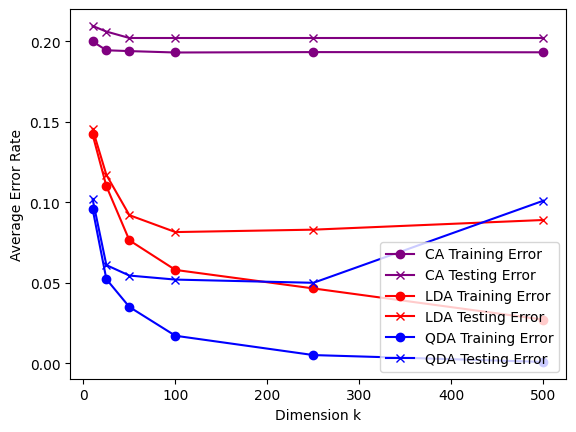

In [47]:
#Plot average error rates. 
fig = plt.figure()

plt.plot(kvalues, avg_train_error_CA, marker = "o", color = "purple")
plt.plot(kvalues, avg_test_error_CA, marker = "x", color = "purple")
plt.plot(kvalues,avg_train_error_LDA,marker="o",color="red")
plt.plot(kvalues,avg_test_error_LDA,marker="x",color="red")
plt.plot(kvalues,avg_train_error_QDA,marker="o",color="blue")
plt.plot(kvalues,avg_test_error_QDA,marker="x",color="blue")

plt.xlabel('Dimension k')
plt.ylabel('Average Error Rate')

plt.legend(['CA Training Error','CA Testing Error','LDA Training Error','LDA Testing Error','QDA Training Error','QDA Testing Error'], loc = 'lower right')
plt.show()